In [151]:
from distutils.command import config


def random_search(problem, function_evaluations=150, **kwargs):
    """
    Function that performs random search on the given problem. It uses the 
    ranges and sampling types defined in GET_RANGES(problem) (see utils.py).

    Arguments:
      - problem (str): the problem identifier
      - function_evaluations (int): the number of configurations to evaluate
      - **kwargs: any other keyword arguments 

    Returns:
      - history (list): A list of the observed losses
      - configs (list): A list of the tried configurations. Every configuration is a dictionary
                        mapping hyperparameter names to the chosen values 
    """

    history = []
    configs = []

    # get all information about the hyperparameters we want to tune for this problem
    # (see utils.py) for the form of this.  
    RANGES = GET_RANGES(problem) 

    #print(RANGES)

    # example of a hyperparameter configuration. you of course want to change the names and values
    # according to the problem and the values you sample
    # config = {
    #     "hypername1": 5, 
    #     "hypername2": 10,
    # }

    
    # once you have a configuration 'config' in the form of a dictionary mapping from 
    # hyperparameter -> value you can evaluate it using this function
    

    #print(loss)

    # TODO: implement the rest of the function
    for j in range(150):
      config={}

      for i in RANGES:
        
        if(RANGES[i]['sample']==0):
          if('condition' in RANGES[i]):
            if(RANGES[i]['condition'](config)):
              if type(RANGES[i]["range"]) == list:
                value=np.random.randint(1,len(RANGES[i]["range"]),1)[0]
                config[i]=RANGES[i]['range'][value]
              else:                
                value=np.random.randint(RANGES[i]["range"][0],RANGES[i]["range"][1],1)[0] #made changes here please check
                config[i]=value
          else:   
            if type(RANGES[i]["range"]) == list:
                value=np.random.randint(1,len(RANGES[i]["range"]),1)[0]
                config[i]=RANGES[i]['range'][value]
            else:
                value=np.random.uniform(RANGES[i]["range"][0],RANGES[i]["range"][1],1)[0] #made changes here please check to take tuples as well
                config[i]=value
        else:
          if('condition' in RANGES[i]):
            if(RANGES[i]['condition'](config)):
              value=np.random.uniform(np.log(RANGES[i]["range"][0]),np.log(RANGES[i]["range"][1]),1)[0]
        
              if(RANGES[i]["type"]==2):
                value=int(np.exp(value))
              config[i]=value
          else:
            value=np.random.uniform(np.log(RANGES[i]["range"][0]),np.log(RANGES[i]["range"][1]),1)[0]
            if(RANGES[i]["type"]==2):
                value=int(np.exp(value))
            config[i]=value
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config))

    return history, configs

def Sample(sample,len_of_ranges):
  if(sample==0):
    value=np.random.randint(1,len_of_ranges,1)[0]
    return value


In [160]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm

def tpe(problem, function_evaluations=150, random_warmup=30, gamma=0.2, n=1, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    for i in range(random_warmup):
        loss,configs=random_search(problem,function_evaluations=100)    

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss

    sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
    good_df, bad_df = good_bad(gamma, sorted_loss_df)
    
    #print(configs)
    df = pd.DataFrame(columns=RANGES.keys())
    for i in range(5):
        config,proba=(sample(RANGES,good_df,bad_df,n))
        loss = GET_CONFIG_PERFORMANCE(config)
        print(loss)
        df.loc[i]=proba
    
    for col in df.columns:
        df[col].plot()
        
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, df):
    
    index_value=int(gamma*(df.shape[0]))
    good_dataframe = df.iloc[:index_value+1]
    bad_dataframe = df.iloc[index_value+1:df.shape[0]]

    #remove all nan values
    good_df=(good_dataframe["configs"].apply(pd.Series))
    bad_df=(bad_dataframe["configs"].apply(pd.Series))

    good_df["loss"]=good_dataframe["loss"]
    bad_df["loss"]=bad_dataframe["loss"]
    
    return good_df, bad_df

# Function that constructs l(x) and samples from it
def sample(RANGES, good_df,bad_df, n):
    
    # List for testing samples
    samples = []
    config={}
    probabilities =[]
    for i in RANGES:  
        #print(i)
        x = good_df[i].dropna()
        y = bad_df[i].dropna()
     
        # If categorical, sample uniform
        if RANGES[i]['type'] == 0:
            sample =  np.random.choice(RANGES[i]['range'])
            samples.append(sample)
            config[i]=sample
            probabilities.append(0)

        else:
            #print(x,y)
            mean, sd = np.mean(x), np.std(x)
            mean_b, sd_b = np.mean(y), np.std(y)
            
            if(RANGES[i]['sample'] == 0):
                l_x = normal_dist(x, mean, sd)
                g_x = normal_dist(y, mean_b, sd_b )
            else:
                l_x = normal_dist(np.log(x), mean, sd)
                g_x = normal_dist(np.log(y), mean_b, sd_b)
                
            # Bounds indicate the truncated gaussians
            a,b = -np.inf, np.inf
            
            # Set prob of values x < a or x > b to '0'
            l_x[x < a], l_x[x > b] = 0, 0
            g_x[y < a], g_x[y > b] = 0, 0

            y_cum = np.cumsum(l_x) / l_x.sum()
            
            # n indicates candidate samples
            yrand = np.random.rand(n)
            sample = np.interp(yrand, y_cum, x)
            samples.append(sample)
            config[i]=sample
            
            probability = (stats.norm.cdf(sample, loc=mean, scale=sd))
            probability_g_x = (stats.norm.cdf(sample, loc=mean_b, scale=sd_b))
            
            probabilities.append((probability/probability_g_x)[0])

    # Added all the samples to a list to get some results   
    #print(probabilities)
    return config,probabilities

[5.9]
[5.9]
[4.]
[4.4]
[4.7]


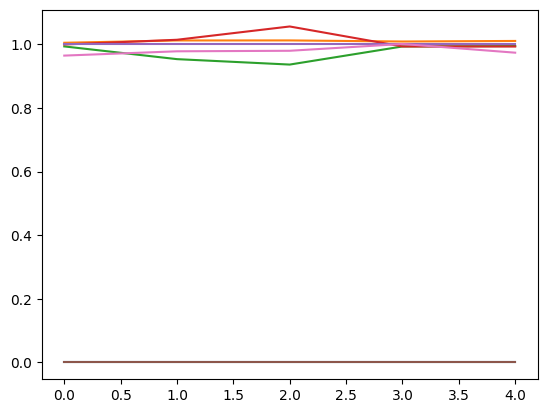

In [161]:
# This gives 1 sample per hyperparameter, since I used n=1 for now
tpe('bad_range')

<AxesSubplot: ylabel='Density'>

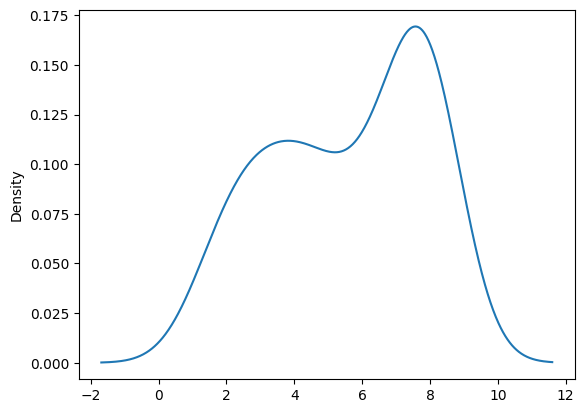

In [18]:
# Below is an example of what the mixture of truncated gaussians looks like for the hyperparameter 'nodes_in_layer_1'
# I warmed up and split the dataframe just like before
# Then I used the 'normal_dist' function to construct l(x), this gives us the points of the PDF
# Apparently dataframes have a built in plot function

gamma = 0.2

for i in range(30):
    loss,configs=random_search("good_range",function_evaluations=100) 
    
hyper_parameters=pd.DataFrame(columns=["configs","loss"])
hyper_parameters["configs"]=configs
hyper_parameters["loss"]=loss

sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
good_df, bad_df = good_bad(gamma, sorted_loss_df)

mean = np.mean(good_df['learning_rate'])
sd = np.std(good_df['learning_rate'])

# Construct l(x)
l_x = normal_dist(good_df['learning_rate'], mean, sd)
# Plot PDF of l(x)
l_x.plot(kind='density')

# The output is as expected: since it is a mixture of truncated gaussians, we do not expect the 'bell curve'.
# We instead expect all Gaussians added together.